In [ ]:
# The MIT License
#  
# Copyright 2021 Brian Reid, Thomas Clunie
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

#**Optimizing Multi-Commodity Factory Locations**

Brian Reid, Tom Clunie

COMP.5430 Artificial Intelligence

Department of Computer Science, University of Massachusetts at Lowell, Lowell, MA, USA

# Environment and data setup

In [ ]:
# dependencies
!pip install pgeocode
!pip install gdown
!pip install folium

In [ ]:
import os

data_directory = "./data/"


# download Walmart data from Tom's Google drive to ./data
import gdown

try:
  os.mkdir( data_directory )
except:
  pass

# download the zip file
zip_url = "https://drive.google.com/uc?id=1aDByWquxZ1pt9zL1EZuONfnXHn28R5id"
zip_file = data_directory + "walmart.zip"
gdown.download( zip_url, zip_file, quiet=False)

# download us postal codes
#!wget http://download.geonames.org/export/zip/US.zip

# backup location:
!wget -O ./data/US.txt https://symerio.github.io/postal-codes-data/data/geonames/US.txt

unzip_postal_codes = False


Downloading...
From: https://drive.google.com/uc?id=1aDByWquxZ1pt9zL1EZuONfnXHn28R5id
To: /content/data/walmart.zip
2.83MB [00:00, 162MB/s]


--2020-12-16 15:58:37--  https://symerio.github.io/postal-codes-data/data/geonames/US.txt
Resolving symerio.github.io (symerio.github.io)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to symerio.github.io (symerio.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2663242 (2.5M) [text/plain]
Saving to: ‘./data/US.txt’

./data/US.txt       100%[===================>]   2.54M  --.-KB/s    in 0.1s    

2020-12-16 15:58:37 (23.7 MB/s) - ‘./data/US.txt’ saved [2663242/2663242]



In [ ]:
# extract data from zip files into ./data/ directory
import zipfile
from pathlib import Path

# unzip the main walmart file
with zipfile.ZipFile( zip_file, 'r') as zip_ref:
    zip_ref.extractall( data_directory )

# unzip child zip files
for f in Path( data_directory ).glob('*.zip'):
  print( "Unzipping {}".format( f ) )
  with zipfile.ZipFile( f, 'r') as zip_ref:
    zip_ref.extractall( data_directory )

# unzip the postal codes if needed
if unzip_postal_codes:
  with zipfile.ZipFile( './US.zip', 'r') as zip_ref:
      zip_ref.extractall( data_directory )
  

Unzipping data/train.csv.zip
Unzipping data/walmart.zip
Unzipping data/test.csv.zip
Unzipping data/sampleSubmission.csv.zip
Unzipping data/features.csv.zip


In [ ]:
# Get/clean/aggregate data
import pandas as pd

# set pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# zip codes
print("\nZIP Codes")
"""
country code      : iso country code, 2 characters
postal code       : varchar(20)
place name        : varchar(180)
admin name1       : 1. order subdivision (state) varchar(100)
admin code1       : 1. order subdivision (state) varchar(20)
admin name2       : 2. order subdivision (county/province) varchar(100)
admin code2       : 2. order subdivision (county/province) varchar(20)
admin name3       : 3. order subdivision (community) varchar(100)
admin code3       : 3. order subdivision (community) varchar(20)
latitude          : estimated latitude (wgs84)
longitude         : estimated longitude (wgs84)
accuracy          : accuracy of lat/lng from 1=estimated, 4=geonameid, 6=centroid of addresses or shape
"""
zip_codes = pd.read_csv( data_directory + 'US.txt', sep='\t', 
                        names=['country_code', 'zip_code', 'name', 'state', 'state_abbreviation', 'county', 'county_data', 'name3', 'code3', 'lat', 'long', 'accuracy' ], dtype="string" 
                        )
zip_codes = zip_codes.astype( {'lat':"float64"}, copy=False)
zip_codes = zip_codes.astype( {'long':"float64"}, copy=False)

print(zip_codes.head(10))




ZIP Codes
  country_code zip_code                 name   state state_abbreviation               county county_data name3 code3      lat      long accuracy
0           US    99553               Akutan  Alaska                 AK       Aleutians East         013  <NA>  <NA>  54.1430 -165.7854        1
1           US    99571             Cold Bay  Alaska                 AK       Aleutians East         013  <NA>  <NA>  55.1858 -162.7211        1
2           US    99583           False Pass  Alaska                 AK       Aleutians East         013  <NA>  <NA>  54.8542 -163.4113        1
3           US    99612            King Cove  Alaska                 AK       Aleutians East         013  <NA>  <NA>  55.0628 -162.3056        1
4           US    99661           Sand Point  Alaska                 AK       Aleutians East         013  <NA>  <NA>  55.3192 -160.4914        1
5           US    99546                 Adak  Alaska                 AK  Aleutians West (CA)         016  <NA>  <NA>  5

In [ ]:
# store features
print("\nWeekly features by store")
weekly_features = pd.read_csv( data_directory + 'features.csv', dtype="string")
weekly_features = weekly_features.astype({'Store':"int64"}, copy=False)
weekly_features = weekly_features.astype({'Temperature':"float64"}, copy=False)
weekly_features = weekly_features.astype({'Fuel_Price':"float64"}, copy=False)
#weekly_features = weekly_features.astype({'CPI':"float64"}, copy=False)
#weekly_features = weekly_features.astype({'Unemployment':"float64"}, copy=False)

print(weekly_features.head(10))

def duplicate_store_data( store_df, store_offset ):
  result = store_df.copy()
  result['Store'] += store_offset
  return result

# expand stores
STORE_MULTIPLIER_FACTOR = 4
weekly_features_expanded = weekly_features.copy()
for _ in range(STORE_MULTIPLIER_FACTOR-1):
  weekly_features_expanded = weekly_features_expanded.append( duplicate_store_data( weekly_features, weekly_features_expanded['Store'].max() ))
weekly_features=weekly_features_expanded

# aggregate weekly data to create store-level features we can use

# get median fuel prices by store
store_features = weekly_features.groupby('Store', as_index=False).agg({'Fuel_Price': ['median']})
store_features.columns = store_features.columns.get_level_values(0)  # flatten


Weekly features by store
   Store        Date  Temperature  Fuel_Price MarkDown1 MarkDown2 MarkDown3 MarkDown4 MarkDown5          CPI Unemployment IsHoliday
0      1  2010-02-05        42.31       2.572      <NA>      <NA>      <NA>      <NA>      <NA>  211.0963582        8.106     FALSE
1      1  2010-02-12        38.51       2.548      <NA>      <NA>      <NA>      <NA>      <NA>  211.2421698        8.106      TRUE
2      1  2010-02-19        39.93       2.514      <NA>      <NA>      <NA>      <NA>      <NA>  211.2891429        8.106     FALSE
3      1  2010-02-26        46.63       2.561      <NA>      <NA>      <NA>      <NA>      <NA>  211.3196429        8.106     FALSE
4      1  2010-03-05        46.50       2.625      <NA>      <NA>      <NA>      <NA>      <NA>  211.3501429        8.106     FALSE
5      1  2010-03-12        57.79       2.667      <NA>      <NA>      <NA>      <NA>      <NA>  211.3806429        8.106     FALSE
6      1  2010-03-19        54.58       2.720     

In [ ]:
# append some random zip codes from the zip_codes dataframe
print("\nSelecting store zip codes")
import random
random.seed(42)  # for repeatability

store_zips = []
store_lats = []
store_longs = []
store_cities=[]
zip_indices = random.sample( range( zip_codes.shape[0] ), store_features.shape[0] )
for i in range( store_features.shape[0] ):
  #idx = random.randint( 0, zip_codes.shape[0]-1 )
  #row = zip_codes.iloc[idx]
  row = zip_codes.iloc[zip_indices[i]]
  print( "Store {}:  selecting zip={}, city={}".format( i, row['zip_code'], row['name'] ) )
  store_zips.append( row['zip_code'] )
  store_lats.append( row['lat'] )
  store_longs.append(row['long'] )
  store_cities.append( row['name'] )

print("\nStore Features")
store_features['zip_code']=store_zips
store_features = store_features.astype( {'zip_code':object}, copy=False)
store_features['lat']=store_lats
store_features['long']=store_longs
store_features['city']=store_cities
print( store_features.dtypes )
print( store_features.head(10) )


Selecting store zip codes
Store 0:  selecting zip=32801, city=Orlando
Store 1:  selecting zip=72478, city=Warm Springs
Store 2:  selecting zip=48460, city=New Lothrop
Store 3:  selecting zip=20615, city=Broomes Island
Store 4:  selecting zip=71129, city=Shreveport
Store 5:  selecting zip=51520, city=Arion
Store 6:  selecting zip=32568, city=Mc David
Store 7:  selecting zip=79556, city=Sweetwater
Store 8:  selecting zip=06110, city=West Hartford
Store 9:  selecting zip=98644, city=Seaview
Store 10:  selecting zip=44046, city=Huntsburg
Store 11:  selecting zip=85355, city=Waddell
Store 12:  selecting zip=85045, city=Phoenix
Store 13:  selecting zip=20408, city=Washington
Store 14:  selecting zip=40004, city=Bardstown
Store 15:  selecting zip=02534, city=Cataumet
Store 16:  selecting zip=37015, city=Ashland City
Store 17:  selecting zip=54440, city=Hatley
Store 18:  selecting zip=72735, city=Goshen
Store 19:  selecting zip=23303, city=Atlantic
Store 20:  selecting zip=67738, city=Grinnel

In [ ]:
# Compute the median fuel price across all stores
fuel_prices = store_features.agg({'Fuel_Price': ['median']})
#store_features.columns = store_features.columns.get_level_values(0)  # flatten
median_fuel_price =fuel_prices.values[0][0]
print("Median fuel price (all stores): {}".format(median_fuel_price) )


Median fuel price (all stores): 3.5105


In [ ]:
print("\nWeekly sales by store, department")
weekly_sales = pd.read_csv( data_directory + 'train.csv' )
weekly_sales.infer_objects()
print(weekly_sales.head(10))

# expand weekly sales data
weekly_sales_expanded = weekly_sales.copy()
for _ in range(STORE_MULTIPLIER_FACTOR-1):
  weekly_sales_expanded = weekly_sales_expanded.append( duplicate_store_data( weekly_sales, weekly_sales_expanded['Store'].max() ))
weekly_sales=weekly_sales_expanded

# aggregate weekly data

# median sales by dept, all stores
print("\nMedian weekly sales by department, all stores")
dept_sales_all_stores = weekly_sales.groupby(['Dept'], as_index=False).agg({'Weekly_Sales': ['median']})
print( dept_sales_all_stores )

# median sales by store, dept
print("\nMedian weekly sales by store, department")
sales = weekly_sales.groupby(['Store', 'Dept'], as_index=False).agg({'Weekly_Sales': ['median']})
sales.columns = sales.columns.get_level_values(0)  # flatten
print( sales )
print( sales.dtypes )

# evaluate mix of departments
print("\nNumber of departments per store")
print( sales.value_counts(subset=['Store']) )


Weekly sales by store, department
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
5      1     1  2010-03-12      21043.39      False
6      1     1  2010-03-19      22136.64      False
7      1     1  2010-03-26      26229.21      False
8      1     1  2010-04-02      57258.43      False
9      1     1  2010-04-09      42960.91      False

Median weekly sales by department, all stores
   Dept Weekly_Sales
              median
0     1    15314.910
1     2    41412.610
2     3     9260.870
3     4    24259.420
4     5    18006.920
5     6     4067.795
6     7    18885.930
7     8    28472.640
8     9    16890.550
9    10    16961.420
10   11    13748.485
11   12     3932.610
12   13    27970.820
13   14    13586.970
14   16   

In [ ]:
# Sanity check:  examine the stats for a particular store
one_store = sales[sales['Store']==1]
print( one_store.describe() )
print( one_store )

       Store       Dept   Weekly_Sales
count   77.0  77.000000      77.000000
mean     1.0  45.896104   19498.710455
std      0.0  30.056344   26564.590333
min      1.0   1.000000       0.000000
25%      1.0  21.000000    2535.580000
50%      1.0  41.000000    8712.440000
75%      1.0  74.000000   27333.830000
max      1.0  99.000000  132945.440000
    Store  Dept  Weekly_Sales
0       1     1     18535.480
1       1     2     45561.850
2       1     3     10366.850
3       1     4     36579.960
4       1     5     21183.420
5       1     6      4132.610
6       1     7     20212.710
7       1     8     35356.120
8       1     9     27333.830
9       1    10     30888.690
10      1    11     23607.730
11      1    12     10724.560
12      1    13     38347.520
13      1    14     13579.210
14      1    16     21143.580
15      1    17      8712.440
16      1    18      2303.360
17      1    19      1229.720
18      1    20      3985.350
19      1    21      7662.310
20      1    22    

In [ ]:
# Example of calculating distance between zip codes/stores
# pgeocode:  https://github.com/symerio/pgeocode
import pgeocode
dist = pgeocode.GeoDistance('us')

s0 = store_features.iloc[8]
s1 = store_features.iloc[40]
print("Distance between store {} in {} and store {} in {}: {}".format( s0['Store'], s0['zip_code'], s1['Store'], s1['zip_code'], dist.query_postal_code( s0['zip_code'], s1['zip_code'] )))


Distance between store 9 in 06110 and store 41 in 58634: 2484.370540549223


In [ ]:
import folium
from functools import lru_cache

@lru_cache(maxsize=None)
def zip_to_lat_long_name( zip ):
  "Convert zip code string to (lat,long,name) tuple for folium using zip_codes var"
  row = zip_codes[zip_codes.zip_code==zip]
  assert(row.shape[0]>0)
  return float(row.lat), float(row.long), row['name'].values[0]

def create_map():
  return folium.Map(location=[35.0,-97.0], tiles='CartoDB positron', zoom_start=5, min_zoom=4)

def add_line_to_map( map, zip_a, zip_b, **shapeprops ):
  "Add a line on a folium map between two zip codes.  shapeprops are kwargs passed to folium.PolyLine"
  # https://python-visualization.github.io/folium/modules.html#folium.vector_layers.PolyLine
  folium.PolyLine( [ zip_to_lat_long_name( zip_a )[:2], zip_to_lat_long_name( zip_b )[:2] ], **shapeprops ).add_to( map )

def add_circle_to_map( map, zip, **kwargs ):
  "Add a circle on a folium map at the specified zip code.  kwargs passed to folium"

  lln = zip_to_lat_long_name( zip )

  folium.Circle(
      location=[ *lln[:2] ], # lat, long
      tooltip=lln[2], #name,
      **kwargs
    ).add_to(map)

def add_marker_to_map( map, zip, **kwargs ):
  "Add a marker on a folium map at the specified zip code.  kwargs passed to folium"

  lln = zip_to_lat_long_name( zip )

  folium.Marker(
      location=[ *lln[:2] ], # lat, long
      tooltip=lln[2], #name,
      **kwargs
    ).add_to(map)


In [ ]:
STORE_MAP_PROPS = { 'color':'blue', 'radius':50 }

store_map = create_map()

for store_zip in store_zips:
  add_circle_to_map( store_map, store_zip, **STORE_MAP_PROPS )


## Store Map

In [ ]:
store_map

In [ ]:
# constants
NUM_FACTORIES = 50
POPULATION_SIZE = 100
TYPES_PER_FACTORY = 75

In [ ]:
# randomly generate the locations of the factories
import pandas as pd

def genFactories(num_factories, zips_df):
  factoryList = []

  for i in range(num_factories):
    index = random.randint(0, zips_df.last_valid_index())
    code = zips_df['zip_code'][index]
    print( zips_df['name'][index] )
    factoryList.append(code)
  return factoryList



In [ ]:
headers = []
for i in range(1, max(sales["Dept"]) +1 ):
  headers.append(i)


In [ ]:
import numpy as np

# create a DF with a zip code and a list of products
# each product with have a binary indicating whether 
# it produces that product (1) or not (0)

factory_list = genFactories(NUM_FACTORIES, zip_codes)
zeros = np.zeros(shape=(NUM_FACTORIES, len(headers)), dtype=int)
factory_df = pd.DataFrame(columns=headers, index=factory_list, data=zeros)
factory_df

# bug - leading zeros are getting cut off
# resolved by loading the orginal zop code DF with all dtype="string" and casting to int/float where needed


Cincinnati
Lynnville
Port Arthur
Pleasanton
Hattiesburg
New York
White Sands Missile Range
Moodys
Heidenheimer
Christmas Valley
Bowdon Junction
Bethesda
Baton Rouge
San Diego
Salemburg
Pine Bluff
Seattle
Brookshire
New Sarpy
Seattle
Virgie
Tyler
Vallejo
APO AA
Sacramento
Pilottown
Santa Barbara
Glendale
Lowell
Birds Landing
Memphis
Burlington
Saint Clair
Garland
Louisville
Groves
Cairo
Skipwith
Alexandria
Brookville
Fayville
Archbald
Rexford
Stanford
Washington
Rehoboth Beach
Atwater
Holdrege
Cincinnati
Woodridge


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
45238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Factory Map

In [ ]:
# display factory locations
FACTORY_MAP_PROPS = { 'color':'crimson', 'radius':50 }
factory_map = create_map()
factory_zips = [ factory_zip for factory_zip in factory_df.index ]
for factory_zip in factory_zips:
  add_circle_to_map( factory_map, factory_zip, **FACTORY_MAP_PROPS )


In [ ]:
factory_map

## Factory-Product Assignment

In [ ]:
# build a list of the departments that we actually use
# use this to refine the dataframes of stores and factories so we dont have too
# many zeros laying around for products that we dont need.
# actually removing the zeros is probably a "nice to have"
active_products = []
for i in range(max(weekly_sales['Dept'])+1):
  if i in weekly_sales['Dept'].values:
    active_products.append(i)
active_products
available_product = list(active_products)

In [ ]:
# select some products to produce from the list of products, up to the static max
# this edits the existing dataframe, should we create a new one?
def assignProductsToFactories(factory_df, active_products, types_per_factory):
  """
  Takes a dataframe of factories with products initialized to zero.
  Selects random products for a factory to produce up to the limit
  and updates those values to 1.
  We keep track of which products we've selected and refresh the list once
  it is empty in order to be sure that every product is selected.
  """
  available_product = list(active_products)
  for i in factory_df.index:
    for j in range(TYPES_PER_FACTORY):
      # if we've cleared the list of products, reset it
      if len(available_product) == 0:
        available_product = list(active_products)
      choice = random.choice(available_product)
      # remove what we chose so no products get left out
      available_product.remove(choice)
      # update our choice to produce the product in the factory DF
      factory_df.at[i, choice] = 1
  return factory_df


In [ ]:
factories_with_products = assignProductsToFactories(factory_df, active_products, TYPES_PER_FACTORY)
factories_with_products.head()


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
45238,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1
42063,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0,1
77640,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1
66075,1,1,0,0,1,1,0,0,1,1,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1
39401,1,0,1,1,0,1,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1


## Assign Products to Stores

In [ ]:
# create a dataframe of stores
# each store has binary bit indicating whether it stocks a procuct or not
def genStoreBase(store_features):
  zeros = np.zeros(shape=(store_features.shape[0], len(headers)), dtype=int)
  stores_df = pd.DataFrame(columns=headers, index=store_features['zip_code'], data=zeros)
  return stores_df

store_base = genStoreBase(store_features)
store_base.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
zip_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def assignProductsToStores(store_base, store_features, sales):
  for index in store_base.index:
    # get the id from the store_features df
    row_data = store_features.loc[store_features['zip_code'] == str(index)]
    store_id = row_data['Store'].values[0]
    # find what products this store sells from sales data df
    store_data = sales.loc[sales["Store"] == store_id]
    for dept in store_data["Dept"]:
      store_base.at[str(index), dept] = 1
  return store_base

stores_df = assignProductsToStores(store_base, store_features, sales)


In [ ]:
stores_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
zip_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32801,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1
72478,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1
48460,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0
20615,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1
71129,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0


In [ ]:

def assignFactoriesToStores( stores_df, factory_df ):
  """
  For each store, randomly assign a factory to each department that the store sells
  :param stores_df: dataframe of stores (1 per row) with binary flag per column, indicating a required assignment
  :param factory_df: dataframe of factories (1 per row) with binary flag per column, indicating production
  :return: dataframe of stores (1 per row) with one randomly-assigned factory per product required
            non-required products will have an empty string for the department zip code
  """
  result = stores_df.copy(deep=True)
  result = result.astype(str).replace("0","") # convert df to strings, remove zeroes

  assert stores_df.shape[1]==factory_df.shape[1]  # ensure # of columns match since we're accessing by index

  for store_idx in result.index: # foreach store
    for dept_idx in range(1,result.shape[1]+1):  # foreach department
      if len(result.at[store_idx,dept_idx])==0:  # product not required
        continue

      # get factories which produce products for this department
      factories = factory_df[factory_df[dept_idx]==1]
      assert factories.shape[0]>0

      # randomly assign a factory from the list
      random_factory_idx =random.randint(0,factories.shape[0]-1)
      result.at[store_idx,dept_idx]=factories.iloc[random_factory_idx].name

  return result

stores_assigned = assignFactoriesToStores( stores_df, factory_df )
print( stores_assigned.head() )


             1      2      3      4      5      6      7      8      9      10     11     12     13     14 15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42 43     44     45     46     47     48     49 50     51     52 53     54     55     56 57     58     59     60 61 62 63 64 65 66     67 68 69 70     71     72 73     74 75 76     77     78     79     80     81     82     83 84     85 86     87 88 89     90     91     92     93     94     95     96     97     98     99
zip_code                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
def get_factories_for_store( store_factory_df, store_zip ):
  """
  Create unique list of factories for the specified store
  :param: store_factory_df stores (rows) and their factories (columns)
  :return: unique list of factory_zip
  """
  store_df = store_factory_df[store_factory_df.index==store_zip]
  assert( store_df.shape[0]>0 )
  result=[ store_df[i][0] for i in range(1,store_df.shape[1]+1) ] # iterate columns
  return list(set(filter(None,result))) # remove duplicates and empties

In [ ]:
STORE_FACTORY_MAP_LINE_PROPS = { 'color':'green', 'weight':0.5, 'opacity': 0.5 }
def create_sourcing_map( store_zips, store_factory_df ):
  "Create a sourcing map for each store in store_zips using store_factory_df, returns folium map"
  result = create_map()

  # add all factories
  for factory_zip in factory_zips:
    add_circle_to_map( result, factory_zip, **FACTORY_MAP_PROPS )

  # add each store
  for store_zip in store_zips:
    add_marker_to_map( result, store_zip, **{} )

    for factory_zip in get_factories_for_store( store_factory_df, store_zip ):
      add_line_to_map( result, store_zip, factory_zip, **STORE_FACTORY_MAP_LINE_PROPS )

  return result

In [ ]:
random_config = assignFactoriesToStores( stores_df, factory_df )

# Draw some lines between stores and their factories in the initial random configuration
# number of stores to display in the store-factory sourcing map
FACTORY_SOURCING_MAP_DISPLAY_N_STORES = 3

store_factory_map_original = create_sourcing_map( store_zips[2:3], random_config )
store_factory_map_original

# Cost Function

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)
def getDistance( zip_a, zip_b ):
  """ 
  Calculate the distance between two zip codes
  :param zip_a zip code 1 string
  :param zip_b zip code 2 string
  :returns float distance in miles
  """
  KM_TO_MILES =  0.62137119223733
  # pgeocode returns km
  return dist.query_postal_code( zip_a, zip_b ) * KM_TO_MILES

In [ ]:
# pandas version was terribly slow. discretize to numpy array
sales_np = sales.to_numpy(dtype=np.int)  

# cost function:
#   factors:  
#     factory zip
#     store zips (only the stores which stock the products that this factory produces)
#     store gas price
#     store weekly sales median (can use as proxy for weight)

SALES_DOLLARS_TO_TONS = 0.0001       # convert sales dollars to tons of product
NATIONAL_MEDIAN_FUEL_PRICE= median_fuel_price  # median from store_features
FIXED_COST_PER_MILE = 0.93        # using https://www.motorcarrierhq.com/tools/calculator-2/ with default values, except zero for diesel costs
#TRUCK_FUEL_ECONOMY = 6.5          # miles per gallon, https://truckingresearch.org/wp-content/uploads/2019/11/ATRI-Operational-Costs-of-Trucking-2019-1.pdf
TON_MILES_PER_GALLON = 100.0      # a truck can move a ton of freight X miles on a gallon of fuel
TRUCK_WEIGHT_TONS = 30000. / 2000.  # empty truck weight, tons   https://www.millerandzois.com/weight-tractor-trailer.html

def calculateTransportCost( zip_a, zip_b, sales_dollars, store_fuel_price ):
  """Calculates the transport cost of the distance between two locations
  :param zip_a, zip_b To/from zip codes
  :param sales_dollars:  sales, in dollars, of a particular store (float)
  :param store_fuel_price:  fuel price, in dollars, of a particular store
  """
  
  distance = getDistance( zip_a, zip_b )  # distance in miles
  sales_weight = sales_dollars * SALES_DOLLARS_TO_TONS  # convert sales $$ to some weight in tons
  avg_fuel_price = ( NATIONAL_MEDIAN_FUEL_PRICE + store_fuel_price ) / 2. # average fuel price per gallon
  cargo_gallons_of_fuel = distance*sales_weight/TON_MILES_PER_GALLON  # variable amt of fuel required to move this many tons of product
  truck_gallons_of_fuel = distance*TRUCK_WEIGHT_TONS/TON_MILES_PER_GALLON

  # sum the costs; fixed costs per mile + variable costs per mile
  variable_costs = (cargo_gallons_of_fuel+truck_gallons_of_fuel)*avg_fuel_price
  fixed_costs = distance*FIXED_COST_PER_MILE

  result = variable_costs+fixed_costs
  #print( "Dist {}, sales_weight {}, cargo gallons {}, truck gallons {}, total cost {}".format( distance, sales_weight, cargo_gallons_of_fuel, truck_gallons_of_fuel, result ) )

  return result

def calculateStoreCost( individual, store_idx, store_sales, store_features ):
  """
  Calculates the cost for a single store, with each department being sourced by a specified zip code
  :param individual
  :param store_idx  the pandas index within the individual for which to calculate cost
  :param store_sales discretized numpy array of columns [store id, dept id, dollars]
  :param store_features pandas feature vector per store
  """
  
  store_zip = str( store_idx ) # store zip
  feat = store_features[store_features.zip_code==store_zip]  # features for this particular store by zip code
  store_fuel_price = float(feat.Fuel_Price)  # fuel price
  fuel_price = ( NATIONAL_MEDIAN_FUEL_PRICE + store_fuel_price ) / 2. # average fuel price per gallon
  store_id = feat.Store.values[0]  # store id
  this_store_sales = store_sales[np.where(store_sales[:,0]==store_id)][:,1:3]
  
  # this lookup on pandas df is terribly slow.  needed to convert to numpy array
  #  store_sales[(sales.Store==store_id) & (sales.Dept==dept_idx)]

  #print('---')
  #print( "Store {}, fuel price {}".format( store_zip, store_fuel_price ) )

  result = 0.0

  # iterate departments
  for dept_idx in range( 1, individual.shape[1]+1):

    # do we have a factory for this dept?
    factory_zip = individual.at[store_idx,dept_idx]
    if not factory_zip:
      continue
    
    # does the store have sales for this dept?
    sales_amt_np = this_store_sales[np.where(this_store_sales[:,0]==dept_idx)][:,1]
    sales_amt = sales_amt_np[0] if len(sales_amt_np) > 0 else 0
    if sales_amt <= 0.:
      continue
    
    # calculate the cost
    dept_cost = calculateTransportCost( factory_zip, store_zip, sales_amt, store_fuel_price )

    result += dept_cost

  return result

def calculateIndividualCost(individual, store_sales, store_features ):
  """Calculates a cost for an individual"""

  result = 0.0
  for store_idx in individual.index: # foreach store
    result += calculateStoreCost( individual, store_idx, store_sales, store_features )
  return result


# this is really slow the first time it's run due to having to populate the zip code distance cache
# print( calculateIndividualCost( random_config, sales_np, store_features ) )


In [ ]:
########
# REPRODUCTION CONSTANTS
########
CROSSOVER_STORES    = 10
CROSSOVER_PRODUCTS  = 10
MUTATION_STORES     = 5
MUTATION_PRODUCTS   = 5

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=None)
def calculateStoreDeptCost( store_zip, factory_zip, dept_idx ):
  """
  Calculate store-dept cost using store, factory zip and index.  Uses globals sales_np and store_features
  """

  feat = store_features[store_features.zip_code==store_zip]  # features for this particular store by zip code
  store_fuel_price = float(feat.Fuel_Price)  # fuel price
  fuel_price = ( NATIONAL_MEDIAN_FUEL_PRICE + store_fuel_price ) / 2. # average fuel price per gallon
  store_id = feat.Store.values[0]  # store id
  this_store_sales = sales_np[np.where(sales_np[:,0]==store_id)][:,1:3]

  # does the store have sales for this dept?
  sales_amt_np = this_store_sales[np.where(this_store_sales[:,0]==dept_idx)][:,1]
  sales_amt = sales_amt_np[0] if len(sales_amt_np) > 0 else 0
  if sales_amt <= 0.:
    return 0.
    
  # calculate the cost
  return calculateTransportCost( factory_zip, store_zip, sales_amt, store_fuel_price )

# stores which unique set of params have been called for the cost fn
_costFnCounter = {}

def execCostFunction( store_zip, factory_zip, dept_idx ):
  "execute/return cost fn"

  h = hash( (store_zip,factory_zip,dept_idx) )
  if not h in _costFnCounter.keys():
    _costFnCounter[h]=True  # add to cache
    
  result = calculateStoreDeptCost( store_zip, factory_zip, dept_idx )
  return result*result

def getCostFunctionCounterLength():
  return len(_costFnCounter)

@lru_cache(maxsize=None)
def getFactoriesForDepartment( dept_idx ):
  "List of factory zips for department index"
  return [ str(row[0]) for row in factory_df[factory_df[dept_idx]==1].iterrows() ]

def assignFactoriesAndCostsToStores( stores_df, factory_df ):
  """
  Returns list of stores and corresponding numpy matrix of y=stores, x=department, x,y= cost
  """

  assert stores_df.shape[1]==factory_df.shape[1]  # ensure # of columns match since we're accessing by index

  stores = [ str(store_idx) for store_idx in stores_df.index ]
  data = np.zeros( (stores_df.shape[0], stores_df.shape[1] ), dtype=np.float32 )

  df = stores_df.copy(deep=True).astype(str).replace("0","") # convert df to strings, remove zeroes

  for i in range(len(stores)): # foreach store index
  
    for dept_idx in range(1,df.shape[1]+1):  # foreach department
      if not df.at[stores[i],dept_idx]:  # product not required
        continue

      # get factories which produce products for this department
      factories = getFactoriesForDepartment(dept_idx)
      assert len(factories)>0

      # randomly assign a factory from the list
      random_factory_zip = random.choice( factories )
      data[i,dept_idx-1] = execCostFunction( stores[i], random_factory_zip, dept_idx )  #calculateStoreDeptCost( stores[i], random_factory_zip, dept_idx )

  return stores, data

from copy import deepcopy

class Individual(object):
  """
  Represents an individual solution to the problem
  data:  tuple of ( [store_zips], np.array of costs )
  """
  def __init__( self, data=None, store=None ):
    self._cost = None
    self.data = data
    if not self.data: # randomly generate
      self.data = assignFactoriesAndCostsToStores( stores_df, factory_df )
    if store:
      idx = self.data[0].index(store)
      self.data = ( [self.data[0][idx]], self.data[1][idx,:].reshape(1,-1) ) # preserve data as row vector

  def clone( self, store=None ):
    return Individual( deepcopy(self.data), store )

  def crossover( self, other, num_stores=CROSSOVER_STORES, num_products=CROSSOVER_PRODUCTS ):  
    """
    Takes two individuals and crosses them to create two offspring.
    Within an individual, we only cross certain stores (stores must match,
    eg. store 2 with store 2).
    Within the store, we cross only a certain number of products by swapping
    their assigned factory zip codes

    :param individual_A: an individual solution (pd dataframe)
    :param individual_B: an individual solution (pd dataframe)
    :param num_stores: number of stores to cross between the individuals
    :param num_products: number of products to cross between the stores

    :return: two offspring Individuals
    """

    # copy the parent data to two new offspring
    # we want to create the offspring while leaving the parents intact
    offspring_A = self.clone()
    offspring_B = other.clone()

    data_shape = self.data[1].shape # cost matrix
    crossover_stores = random.sample( range( data_shape[0] ), num_stores )
    crossover_depts = random.sample( range( data_shape[1] ), num_products )

    for store in crossover_stores:
      for dept in crossover_depts:
        #print("Swapping {} and {}".format( offspring_A.data[1][store,dept], offspring_B.data[1][store,dept] ) )
        temp = offspring_A.data[1][store,dept]
        offspring_A.data[1][store,dept] = offspring_B.data[1][store,dept]
        offspring_B.data[1][store,dept]= temp
        #print("Result: {} and {}".format( offspring_A.data[1][store,dept], offspring_B.data[1][store,dept] ) )

    # erased cached cost values
    offspring_A._cost = None
    offspring_B._cost = None

    return offspring_A, offspring_B

  def mutate( self, mutation_factor_store=MUTATION_STORES, mutation_factor_product=MUTATION_PRODUCTS ):
    """
    Mutate this individual by randomly selecting a new (valid) zip code
    for some of its products.

    :param mutation_factor_store: int - number of stores to mutate
    :param mutation_factor_product: int - number of products per store to mutate (1-99 in our case)
    :returns int - number of times a non-cached cost function was executed
    """

    self._cost = None

    # select store, dept indices to mutate.  uniform random sampling w/o replacement
    stores = random.sample( range( len( self.data[0] ) ), mutation_factor_store )
    depts = random.sample( range(1, factory_df.shape[1] + 1 ), mutation_factor_product )

    for store_idx in stores:
      for dept_idx in depts:
        #print("Mutating:  old factory cost {}".format( self.data[1][store_idx,dept_idx-1] ) )
        # randomly choose a new factory for this dept
        # get factories which produce products for this department
        
        factories = getFactoriesForDepartment( dept_idx )
        if len(factories) == 0: # invalid dept
          continue
        random_factory_zip = random.choice( factories )
        
        self.data[1][store_idx,dept_idx-1] = execCostFunction( self.data[0][store_idx], random_factory_zip, dept_idx )  #calculateStoreDeptCost( stores[i], random_factory_zip, dept_idx ) #calculateStoreDeptCost( self.data[0][store_idx], random_factory_zip, dept_idx )
        #print("Mutating:  new factory cost {}".format( self.data[1][store_idx,dept_idx-1] ) )    
  
  def cost( self ):
    if not self._cost:
      self._cost = np.sum(self.data[1])
    return self._cost
  
  def merge( self, other ):
    "merge the genes (stores) from other into self"
    for store in other.data[0]:
      self_store_idx = self.data[0].index(store)  # find my corresponding index
      other_store_idx = other.data[0].index(store) # find other's index
      #print("Merge before: {}".format( np.sum(self.data[1][self_store_idx,:] ) ))
      self.data[1][self_store_idx,:] = other.data[1][other_store_idx,:]
      #print("Merge after: {}".format( np.sum(self.data[1][self_store_idx,:] ) ))
    self._cost = None


# Brute force solution
Find the global minimum and establish a benchmark for comparison

stores * departments * choices per department

In [ ]:
thesum = 0
for dept_idx in range( 1, stores_df.shape[1]+1 ):  # foreach department in store
  thesum += len(getFactoriesForDepartment( dept_idx ))
max_cost_fn_evals = thesum*stores_df.shape[0]
print( "Possible combinations of store departments and factories: {}".format( max_cost_fn_evals ) )


Possible combinations of store departments and factories: 574740


In [ ]:
import math

_costFnCounter={}
print(getCostFunctionCounterLength())

def brute_force( store_sales, store_features ):
  "solve the problem via brute force.  Return number of iterations, optimal configuration, and total cost"
  bf = assignFactoriesToStores( stores_df, factory_df )
  i = 0
  total_cost = 0.0

  for store_idx in bf.index: # foreach store

    store_zip = str( store_idx ) # store zip
    feat = store_features[store_features.zip_code==store_zip]  # features for this particular store by zip code
    store_fuel_price = float(feat.Fuel_Price)  # fuel price
    store_id = feat.Store.values[0]  # store id
    this_store_sales = store_sales[np.where(store_sales[:,0]==store_id)][:,1:3]

    for dept_idx in range( 1, bf.shape[1]+1 ):  # foreach department in store

      # iterate all possible factories, choose the cheapest
      factories = getFactoriesForDepartment( dept_idx ) #factory_df[factory_df[dept_idx]==1]

      min_cost = math.inf
      min_cost_factory = None
      for factory_idx in factories:
        i += 1  # increment interations
        cost = execCostFunction( store_zip, str(factory_idx), dept_idx )  # returns 0 if no sales
        if cost > 0. and cost < min_cost:
          min_cost = cost
          min_cost_factory = factory_idx
      # update result bf with best factory
      if not min_cost_factory:
        continue
      bf.at[store_idx,dept_idx]=min_cost_factory
      total_cost += min_cost

  return i, bf, total_cost


# takes about 10 minutes (631 secs) to run the first time.  Most of that is distance lookup.  ~10 secs after that.  based on store expansion multiplier = 4
"""
Found global minimum of 7367577414.311979 in 574740 iterations
Best cost (200% solution): 14735154828.623959
Best cost (150% solution): 11051366121.467968
Best cost (125% solution): 9209471767.889975
"""
iters = 576000
best_cost = 6891767098.744997
best_config = ""

iters, best_config, best_cost = brute_force( sales_np, store_features )

print("Found global minimum of {} in {} iterations".format( best_cost,iters ))

best_cost_200 = best_cost*2.
best_cost_150 = best_cost*1.5
best_cost_125 = best_cost*1.25

print("Best cost (200% solution): {}".format( best_cost_200 ) )
print("Best cost (150% solution): {}".format( best_cost_150 ) )
print("Best cost (125% solution): {}".format( best_cost_125 ) )

print("Best configuration:")
print( best_config )


0
Found global minimum of 7367577414.311979 in 574740 iterations
Best cost (200% solution): 14735154828.623959
Best cost (150% solution): 11051366121.467968
Best cost (125% solution): 9209471767.889975
Best configuration:
             1      2      3      4      5      6      7      8      9      10     11     12     13     14 15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49     50     51     52 53     54     55     56 57     58     59     60 61 62 63 64     65 66     67 68 69 70     71     72 73     74 75 76     77     78     79     80     81     82     83 84     85 86     87 88 89     90     91     92     93     94     95     96     97     98     99
zip_code                                                                                                                                            

### Display Optimal Sourcing Map for a selected store

In [ ]:
store_factory_map_result = create_sourcing_map( store_zips[2:3], best_config )
store_factory_map_result


In [ ]:
import matplotlib.pyplot as plt

def plot_history( history ):
  "Make a plot of the cost(s) vs iteration"
  # Lets make a graph of the of the algorithm history
  x = [ h['iteration'] for h in history ]

  # add target cost line(s)
  for h in history:
    h['target_cost_200%']= best_cost_200
    h['global minimum'] = best_cost

  y_keys = list(history[0].keys())
  y_keys.remove('iteration')

  _, ax = plt.subplots()
  ax.set_xlabel('iteration')
  ax.set_ylabel('cost')

  # everything but cost_fn_evals
  for y_key in y_keys:
    if y_key == 'cost_fn_evals':
      continue
    y = [h[y_key] for h in history]

    line, = ax.plot( x, y )
    line.set_label(y_key)
  ax.legend( )

  # cost fn evals
  if 'cost_fn_evals' in y_keys:
    
    #for h in history:
    #  h['max_cost_fn_evals']= max_cost_fn_evals

    _, ax2 = plt.subplots()
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('cost fn evals')

    y = [h['cost_fn_evals'] for h in history]
    y2 = [max_cost_fn_evals for _ in history ]

    line, = ax2.plot( x, y )
    line.set_label( 'cost_fn_evals' )

    line2, = ax2.plot( x, y2 )
    line2.set_label( 'max_cost_fn_evals' )

    ax2.legend( )

  plt.show()


# Steady State GA

(Version 2) Select 2 individuals from population for offspring creation.  Create 2 children with crossover and mutation.  Then select the best 2 (of 4) individuals for placement back into the population

https://www.cs.unm.edu/~neal.holts/dga/optimizationAlgorithms/steadyStateGA.html

In [ ]:
# Steady-state GA version 2
def ss_ga( population_in, niters, crs_stores = CROSSOVER_STORES, crs_products=CROSSOVER_PRODUCTS, mut_stores=MUTATION_STORES, mut_products=MUTATION_PRODUCTS, notify=True ):
  "steady-state ga"

  history=[]
  population = list(population_in)

  notifications = [ best_cost_200, best_cost_150 ] if notify else []
  notifications_complete = [ False, False ]
  MAX_COST_FUNCTIONS = 500000

  for i in range(niters):
    
    # gather metrics for this generation
    history.append({ 'iteration': i, 
                          'mean_cost':sum([i.cost() for i in population])/len(population), 
                          #'mean_cost_top_n': sum([i.cost() for i in population_ss[:2]])/float(2),
                          #'top_1':population_ss[0].cost(),
                          'cost_fn_evals': getCostFunctionCounterLength()
                          })

    # output
    if i > 0 and ( i % 500 ) == 0:
      print(history[-1])

    # select 2 individuals
    parent_idxs = random.sample( range( len( population ) ), 2 )
    parentA = population[parent_idxs[0]]
    parentB = population[parent_idxs[1]]
    
    # crossover best individuals, mutate offspring, add to population
    offA, offB = parentA.crossover( parentB, crs_stores, crs_products )
    offA.mutate( mut_stores, mut_products )
    offB.mutate( mut_stores, mut_products )

    # best two go back in the population
    best = sorted( [ parentA, parentB, offA, offB ], key=lambda i : i.cost() )
    population[parent_idxs[0]]=best[0]
    population[parent_idxs[1]]=best[1]

    # check for notifications/termination
    if notify:
      if getCostFunctionCounterLength() > MAX_COST_FUNCTIONS:
        print("Exceeded max cost functions, terminating")
        return population, history

      if int(best[0].cost()) <= int(best_cost):
        print("Found global minimum")
        return population, history

      for n in range(len(notifications)):
        if not notifications_complete[n] and int(best[0].cost()) <= int(notifications[n]):
          print("Found notification: {}".format( notifications[n] ) )
          print( history[-1] )
          notifications_complete[n]=True

  return population, history


{'iteration': 500, 'mean_cost': 77968468650.66667, 'cost_fn_evals': 39701}
{'iteration': 1000, 'mean_cost': 75675435008.0, 'cost_fn_evals': 40478}
{'iteration': 1500, 'mean_cost': 73398479530.66667, 'cost_fn_evals': 41252}
{'iteration': 2000, 'mean_cost': 71564200618.66667, 'cost_fn_evals': 41998}
{'iteration': 2500, 'mean_cost': 69697194666.66667, 'cost_fn_evals': 42746}


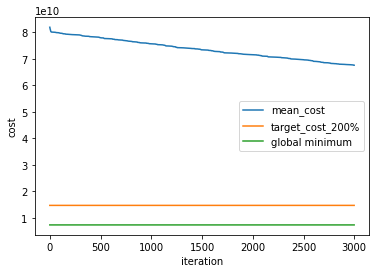

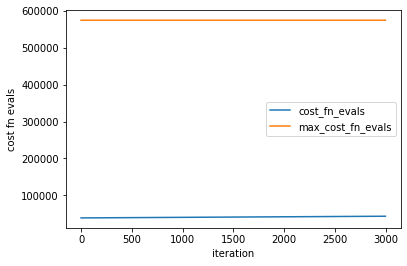

In [ ]:
"""
SSGA
"""

ITERATIONS_SS = 1000000
ITERATIONS_SS = 3000
POPULATION_SIZE_SS = 3

MUTATION_STORES_SS = 1
MUTATION_PRODUCTS_SS = 1
CROSSOVER_STORES_SS = 90
CROSSOVER_PRODUCTS_SS = 50

_costFnCounter={}
population_ss, history_ss = ss_ga( [ Individual() for _ in range(POPULATION_SIZE_SS) ], ITERATIONS_SS, CROSSOVER_STORES_SS, CROSSOVER_PRODUCTS_SS, MUTATION_STORES_SS, MUTATION_PRODUCTS_SS )
plot_history( history_ss )


# Generational GA - Elitism
Select the N best individuals from the population to start the next generation.  From these individuals, create offspring with crossover and mutation to fill out the population.

In [ ]:

ITERATIONS_ELITE = 1000000
POPULATION_SIZE_ELITE = 4 
SELECT_N_ELITE = 2    # select this many elite individuals from each generation for offspring creation

MUTATION_STORES_ELITE = 1
MUTATION_PRODUCTS_ELITE = 1
CROSSOVER_STORES_ELITE = 90
CROSSOVER_PRODUCTS_ELITE = 50

def eliteGA( population, niters, select_top_n, crs_stores=CROSSOVER_STORES_ELITE, crs_products=CROSSOVER_PRODUCTS_ELITE, mut_stores=MUTATION_STORES_ELITE, mut_products=MUTATION_PRODUCTS_ELITE, notify=True ):
  ""

  sz = len(population)
  result = list(population)
  history = []

  notifications = [ best_cost_200, best_cost_150 ] if notify else []
  notifications_complete = [ False, False ]
  MAX_COST_FUNCTIONS = 500000

  for n in range(niters):

    # sort by fitness, ascending
    result = sorted( result, key=lambda i : i.cost() )

    # gather metrics for this generation
    history.append({ 'iteration': n, 
                          'mean_cost':sum([i.cost() for i in result])/len(result), 
                          #'mean_cost_top_n': sum([i.cost() for i in result[:select_top_n]])/float(select_top_n),
                          'cost_fn_evals': getCostFunctionCounterLength()
                          })
    
    if notify:
      # check for notifications/termination
      if getCostFunctionCounterLength() > MAX_COST_FUNCTIONS:
        print("Exceeded max cost functions, terminating")
        return population, history
      
      if int(result[0].cost()) <= int(best_cost):
        print("Found global minimum")
        return population, history

      for k in range(len(notifications)):
        if not notifications_complete[k] and int(result[0].cost()) <= int(notifications[k]):
          print("Found notification: {}".format( notifications[k] ) )
          print( history[-1] )
          notifications_complete[k]=True

    # output
    if n > 0 and ( n % 1000 ) == 0:
      print(history[-1])

    # grab the N best for the new generation
    result=result[:select_top_n]

    # create offspring until POPULATION_SIZE reached
    offspring = []

    while ( len(result) + len(offspring) ) < sz:
      # randomly select two elites (uniform random sample without replacement)
      parents = random.sample( result, 2 )

      # crossover parents, mutate offspring, add to population
      offA, offB = parents[0].crossover( parents[1], crs_stores, crs_products )
      offA.mutate( mut_stores, mut_products )
      offspring.append(offA)

      offB.mutate( mut_stores, mut_products )
      offspring.append(offB)
    
    result += offspring

    # maintain population size in case too many offspring were generated (ie SELECT_N_ELITE is odd)
    result = result[:sz]
  
  return result, history


Creating initial population...
{'iteration': 0, 'mean_cost': 80760885248.0, 'cost_fn_evals': 51360}
{'iteration': 1000, 'mean_cost': 71741505536.0, 'cost_fn_evals': 52845}
{'iteration': 2000, 'mean_cost': 68523741184.0, 'cost_fn_evals': 54310}
{'iteration': 3000, 'mean_cost': 64869641216.0, 'cost_fn_evals': 55790}
{'iteration': 4000, 'mean_cost': 61821627392.0, 'cost_fn_evals': 57235}
{'iteration': 5000, 'mean_cost': 58970330112.0, 'cost_fn_evals': 58718}
{'iteration': 6000, 'mean_cost': 56201371648.0, 'cost_fn_evals': 60184}
{'iteration': 7000, 'mean_cost': 53305225216.0, 'cost_fn_evals': 61634}
{'iteration': 8000, 'mean_cost': 51094657024.0, 'cost_fn_evals': 63092}
{'iteration': 9000, 'mean_cost': 48756280320.0, 'cost_fn_evals': 64566}
{'iteration': 10000, 'mean_cost': 46759491584.0, 'cost_fn_evals': 66002}
{'iteration': 11000, 'mean_cost': 44763689984.0, 'cost_fn_evals': 67433}
{'iteration': 12000, 'mean_cost': 42902568960.0, 'cost_fn_evals': 68882}
{'iteration': 13000, 'mean_cost':

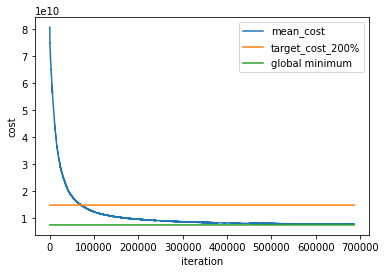

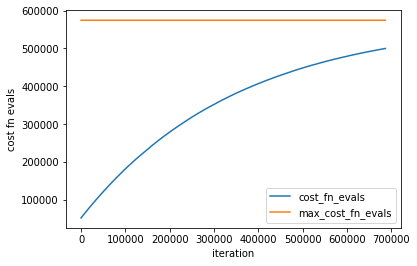

In [ ]:
"""
Elitism:  4/2/90/50/1/1
"""

POPULATION_SIZE_ELITE = 4 #
SELECT_N_ELITE = 2 # select this many elite individuals from each generation for offspring creation
CROSSOVER_STORES_ELITE = 90
CROSSOVER_PRODUCTS_ELITE = 50
MUTATION_STORES_ELITE = 1
MUTATION_PRODUCTS_ELITE = 1

_costFnCounter={}
print("Creating initial population...")
population_elite, history_elite = eliteGA( [ Individual() for _ in range(POPULATION_SIZE_ELITE) ], ITERATIONS_ELITE, SELECT_N_ELITE,
                                          CROSSOVER_STORES_ELITE, CROSSOVER_PRODUCTS_ELITE, MUTATION_STORES_ELITE, MUTATION_PRODUCTS_ELITE
                                          )

# display elite history
plot_history(history_elite)

# Generational GA

Select two individuals to cross via a tournament.
Create 2 offspring with those parents.
Put those offspring into a new generation.
Repeat until the new generation is the same size as the preceding generation.

In [ ]:
# Generational v2
ITERATIONS_GEN = 1000000
POPULATION_SIZE_GEN = 10
CROSSOVER_STORES_GEN = 90
CROSSOVER_PRODUCTS_GEN = 50
MUT_STORES_GEN = 1
MUT_PRODUCTS_GEN = 1

def genGA(population, interations, crs_stores=CROSSOVER_STORES_GEN, crs_products=CROSSOVER_PRODUCTS_GEN, mut_stores=MUT_STORES_GEN, mut_products=MUT_PRODUCTS_GEN, notify=True):
  history = []
  done = False

  notifications = [ best_cost_200, best_cost_150 ] if notify else []
  notifications_complete = [ False, False ]
  MAX_COST_FUNCTIONS = 500000
  
  for i in range(interations):

    if done:
      break

    history.append({ 
        'iteration': i, 
        'mean_cost':sum( [ i.cost() for i in population ] )/len( population ),
        'cost_fn_evals': getCostFunctionCounterLength()
        })

    if notify:
      # check for notifications/termination
      if getCostFunctionCounterLength() > MAX_COST_FUNCTIONS:
        print("Exceeded max cost functions, terminating")
        return population, history
      
      best_individ = sorted( population, key=lambda i : i.cost() )[0]
      if int(best_individ.cost()) <= int(best_cost):
        print("Found global minimum")
        return population, history

      for k in range(len(notifications)):
        if not notifications_complete[k] and int(best_individ.cost()) <= int(notifications[k]):
          print("Found notification: {}".format( notifications[k] ) )
          print( history[-1] )
          notifications_complete[k]=True

    if i > 0 and ( i % 1000 == 0 ):
      print(history[-1])
    
    newPop = []
    while len(newPop) < len(population):

      # randomly create two groups
      tmp = list(population)
      random.shuffle(tmp)
      partition = math.floor(len(tmp)/2)
      groupA = sorted( tmp[:partition], key=lambda i : i.cost() )
      groupB = sorted( tmp[partition + 1:], key=lambda i : i.cost() )
      parentA = groupA[0]
      parentB = groupB[0]

      offA, offB = parentA.crossover( parentB, crs_stores, crs_products )
      offA.mutate( mut_stores, mut_products )
      offB.mutate( mut_stores, mut_products )
      newPop.append(offA)
      newPop.append(offB)
    
    population = list(newPop)[:len(population)]

  return population, history


Creating initial population...
{'iteration': 1000, 'mean_cost': 59447355801.6, 'cost_fn_evals': 125449}
{'iteration': 2000, 'mean_cost': 49830856704.0, 'cost_fn_evals': 131762}
{'iteration': 3000, 'mean_cost': 43434047078.4, 'cost_fn_evals': 137913}
{'iteration': 4000, 'mean_cost': 38108709273.6, 'cost_fn_evals': 144070}
{'iteration': 5000, 'mean_cost': 33945272729.6, 'cost_fn_evals': 150148}
{'iteration': 6000, 'mean_cost': 30466340659.2, 'cost_fn_evals': 156094}
{'iteration': 7000, 'mean_cost': 27629619814.4, 'cost_fn_evals': 161917}
{'iteration': 8000, 'mean_cost': 25400768512.0, 'cost_fn_evals': 167750}
{'iteration': 9000, 'mean_cost': 23684791910.4, 'cost_fn_evals': 173554}
{'iteration': 10000, 'mean_cost': 22066078515.2, 'cost_fn_evals': 179191}
{'iteration': 11000, 'mean_cost': 20613249843.2, 'cost_fn_evals': 184715}
{'iteration': 12000, 'mean_cost': 19512663040.0, 'cost_fn_evals': 190251}
{'iteration': 13000, 'mean_cost': 18579850035.2, 'cost_fn_evals': 195651}
{'iteration': 14

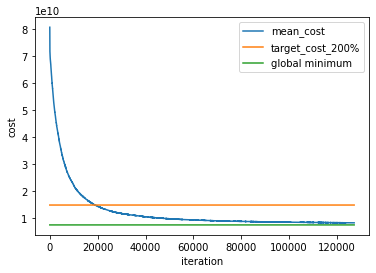

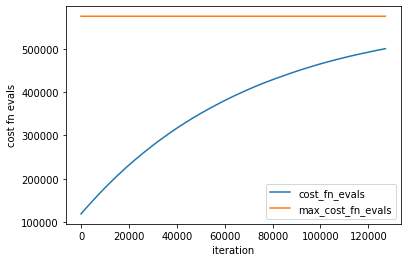

In [ ]:
"""
Generational:  10/90/50/1/1
"""

POPULATION_SIZE_GEN = 10
CROSSOVER_STORES_GEN = 90
CROSSOVER_PRODUCTS_GEN = 50
MUTATION_STORES_GEN = 1
MUTATION_PRODUCTS_GEN = 1

_costFnCounter={}
print("Creating initial population...")
population_gen0 = [ Individual() for _ in range(POPULATION_SIZE_GEN) ]
finalPop, history_gen = genGA(population_gen0, ITERATIONS_GEN, CROSSOVER_STORES_GEN, CROSSOVER_PRODUCTS_GEN, MUTATION_STORES_GEN, MUTATION_PRODUCTS_GEN )
plot_history( history_gen )

# ABC
https://en.wikipedia.org/wiki/Artificial_bee_colony_algorithm

https://abc.erciyes.edu.tr/


In [ ]:
BEE_PATIENCE=3
BEE_GREEDY_MUTATE_LIMIT=1  # when exploring a food source, attempt to mutate up to this many times
BEE_CROSSOVER_PRODUCTS=50
BEE_MUTATION_PRODUCTS=1

import numpy as np

class Bee(object):
  def __init__( self, food_source=None ):
    self.assign( food_source )
    self.best_food = None  # individual bee memory
    self.patience = 0

  def is_employed( self ):
    return self.food_source is not None

  def give_up( self ):
    self.food_source = None

  def assign( self, food_source, neighbor=False ):
    self.food_source = food_source
    self.patience=BEE_PATIENCE
    if neighbor:  # need to clone food source, mutate/crossover
      self.food_source = self.food_source.clone()
      if self.best_food:  # have we eaten food before that has been abandoned?  see if a crossover is advantageous
        foodA, foodB = self.food_source.crossover( self.best_food, 1, BEE_CROSSOVER_PRODUCTS )
        self.food_source = sorted( [ foodA, foodB, self.food_source ], key=lambda f : f.cost() )[0]
      else:
        self.food_source.mutate(1,BEE_MUTATION_PRODUCTS)


  def evaluate_food( self ):
    assert( self.food_source )
    nectar = self.food_source.cost()

    if not self.best_food:
      self.best_food = self.food_source
    elif nectar < self.best_food.cost():
      self.best_food = self.food_source.clone()
      self.patience = BEE_PATIENCE
    else:
      self.patience -= 1

      # greedy mutate, max N times
      for _ in range( BEE_GREEDY_MUTATE_LIMIT ):
        self.food_source.mutate(1,BEE_MUTATION_PRODUCTS)
        if self.food_source.cost() < nectar:  #we have an improvement
          break

    return nectar

class BeeHive(object):
  def __init__( self, food, random_food_generator ):

    self.nfood = len(food)
    self.bees = [Bee( f ) for f in food ] # worker bees to food sources
    self.bees.extend( [Bee() for _ in self.bees ] ) # onlookers
    self.random_food_generator = random_food_generator

  def run( self, niters ):

    history = []

    for n in range(niters):

      current_employees = list(filter( None, [ b if b.is_employed() else None for b in self.bees ] ))
      
      # evaluate sources
      for b in current_employees:
        b.evaluate_food()

      # best known food source
      best_food_source = min( self.bees, key=lambda b : math.inf if b.best_food is None else b.best_food.cost() ).best_food
      
      # send watchers to neighboring food sources based on probability, lower cost is better
      current_watchers = list(filter( None, [ b if not b.is_employed() else None for b in self.bees ] ))      

      if current_employees:
        
        best_costs = [ e.best_food.cost() for e in current_employees ]
        #assign higher probabilities to lower costs
        # squaring cost doesn't seem to improve selection much
        assign_probabilities = np.array([ 1.0 - ( c / sum(best_costs) ) for c in best_costs ])/min(best_costs)
        assign_probabilities = assign_probabilities / np.sum(assign_probabilities)
        #print(assign_probabilities)
        destinations = random.choices( current_employees, weights=assign_probabilities, k=len(current_watchers) )      

        for idx in range(len(destinations)):
          current_watchers[idx].assign( destinations[idx].best_food, True )

      # assign remaining bees to best food with mutation
      for b in self.bees:
        if not b.is_employed():
          b.assign(best_food_source,True)
      
      # abandon food sources where out of patience
      for b in self.bees:
        if b.is_employed() and b.patience < 0:
          b.give_up()
          r = random.randint(0,100)
          if r < 0 and self.random_food_generator:# make bee a random scout (0=disabled)
            b.assign( self.random_food_generator() )
          elif r < 15:  # just go after the best known food w/ mutation
            b.assign( best_food_source, True )
          # else, leave as observer for next iteration

      history.append({ 'iteration': n, 
                'mean_cost':sum( best_costs )/len( best_costs ),
                #'top_1_cost': sorted(best_costs)[0],
                'cost_fn_evals': getCostFunctionCounterLength()
                })
      
      if n > 0 and n % 1000 == 0:
        print( history[-1] )

    # return the same # of input food
    result_pop = list( sorted( filter(None, [ b.best_food for b in self.bees ] ), key=lambda f : f.cost() ) )
    while len( result_pop ) < self.nfood:  # fill out population if needed
      result_pop.append(best_food_source) 

    return result_pop[:self.nfood], history


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


{'iteration': 1000, 'mean_cost': 77954146304.0, 'cost_fn_evals': 28421}
{'iteration': 2000, 'mean_cost': 74355118080.0, 'cost_fn_evals': 30539}
{'iteration': 3000, 'mean_cost': 71278833664.0, 'cost_fn_evals': 32644}
{'iteration': 4000, 'mean_cost': 68685004800.0, 'cost_fn_evals': 34770}
{'iteration': 5000, 'mean_cost': 65981044736.0, 'cost_fn_evals': 36844}
{'iteration': 6000, 'mean_cost': 63474565120.0, 'cost_fn_evals': 38919}
{'iteration': 7000, 'mean_cost': 60828643328.0, 'cost_fn_evals': 41016}
{'iteration': 8000, 'mean_cost': 58534210560.0, 'cost_fn_evals': 43081}
{'iteration': 9000, 'mean_cost': 56409360384.0, 'cost_fn_evals': 45128}
{'iteration': 10000, 'mean_cost': 54741357568.0, 'cost_fn_evals': 47141}
{'iteration': 11000, 'mean_cost': 53269638144.0, 'cost_fn_evals': 49192}
{'iteration': 12000, 'mean_cost': 51383422976.0, 'cost_fn_evals': 51248}
{'iteration': 13000, 'mean_cost': 50090261162.666664, 'cost_fn_evals': 53296}
{'iteration': 14000, 'mean_cost': 48677594112.0, 'cost_

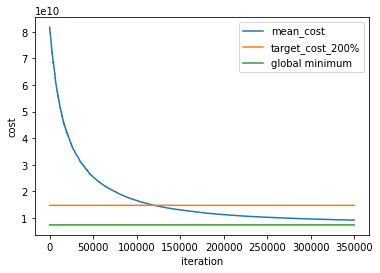

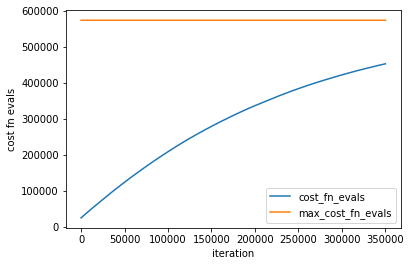

In [ ]:
_costFnCounter={}
hive = BeeHive( [Individual() for _ in range(2)], lambda : Individual() )
abc_pop, abc_history = hive.run( 350000 )
plot_history( abc_history )

# Hybrid GA + DnC

Store-level GA to create new generation

Create a population at the store level rather than set-level.  Run GA for each store level, create a new population

In [ ]:

def hybrid_ga( population, niters, ga ):
  "perform hybrid DnC + GA using ga function"

  result = list(population)
  history = []
  notifications = [ best_cost_200, best_cost_150 ]
  notifications_complete = [ False, False ]
  MAX_COST_FUNCTIONS = 500000

  for n in range(niters):
    # create new population based on previous population
    new_population = [i.clone() for i in result]

    # for each allele in input population
    #   create pool of candidates
    #   perform n rounds of GA
    #   add gene to new population
    for gene_idx in population[0].data[0]: #store
      
      # use previous generation to create subpopulation gene specimens
      subpopulation=[ p.clone(gene_idx) for p in result ]
      
      # do GA on subpopulation
      subpopulation_ga = ga( subpopulation )

      # replace alleles in new population
      # assignment strategy?
      assert( len(subpopulation_ga)==len(new_population) )
      targets = random.sample( new_population, len(new_population) )
      for i in range(len(targets)):
        targets[i].merge(subpopulation_ga[i]) # merge alleles together
    
    # set result
    result = new_population

    # global GA here appears to reduce performance 
    #result, _ = genGA( new_population, 20, 10, 5, 1, 1 )
    #result, _ = eliteGA( new_population, 1, len(new_population)//2, 5, 5, 1, 1 )

    # generate history
    history.append({ 'iteration': n, 
                    'mean_cost':sum( [ i.cost() for i in result ] )/len( result ),
                    #'top_1_cost': sorted([ i.cost() for i in result ])[0],
                    'cost_fn_evals': getCostFunctionCounterLength()
                    })
    
    if getCostFunctionCounterLength() > MAX_COST_FUNCTIONS:
      print("Exceeded max cost functions, terminating")
      return result, history
    
    best_individ = sorted( result, key=lambda i : i.cost() )[0]
    for k in range(len(notifications)):
      if not notifications_complete[k] and int(best_individ.cost()) <= int(notifications[k]):
        print("Found notification: {}".format( notifications[k] ) )
        print( history[-1] )
        notifications_complete[k]=True

    if ( n % 10 == 0 ):
      print(history[-1])

  return result, history


{'iteration': 0, 'mean_cost': 50699993088.0, 'cost_fn_evals': 41690}
{'iteration': 10, 'mean_cost': 29609878186.666668, 'cost_fn_evals': 68270}
{'iteration': 20, 'mean_cost': 22046898858.666668, 'cost_fn_evals': 93625}
{'iteration': 30, 'mean_cost': 17670442325.333332, 'cost_fn_evals': 117638}
{'iteration': 40, 'mean_cost': 15084336128.0, 'cost_fn_evals': 140413}
Found notification: 14735154828.623959
{'iteration': 42, 'mean_cost': 14721851392.0, 'cost_fn_evals': 144887}
{'iteration': 50, 'mean_cost': 13516145322.666666, 'cost_fn_evals': 162115}
{'iteration': 60, 'mean_cost': 12370256896.0, 'cost_fn_evals': 182528}
{'iteration': 70, 'mean_cost': 11552651946.666666, 'cost_fn_evals': 202237}
Found notification: 11051366121.467968
{'iteration': 78, 'mean_cost': 11023251797.333334, 'cost_fn_evals': 217083}
{'iteration': 80, 'mean_cost': 10917547690.666666, 'cost_fn_evals': 220750}
{'iteration': 90, 'mean_cost': 10411915605.333334, 'cost_fn_evals': 238428}
{'iteration': 100, 'mean_cost': 10

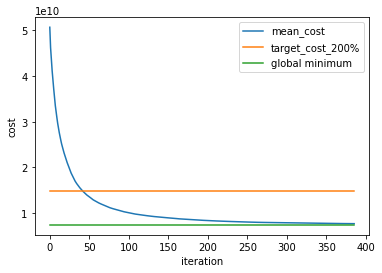

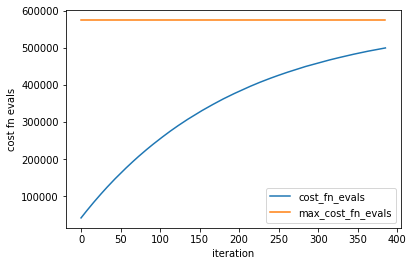

In [ ]:
"""
Hybrid + SSGA
"""

niters = 1000
subiters = 10
popsize = 3

_costFnCounter={}
ga = lambda pop : ss_ga( pop, subiters, 1, 50, 1, 1, False )[0]
_, hybrid_h = hybrid_ga( [ Individual() for _ in range(popsize) ], niters, ga )
plot_history( hybrid_h )


{'iteration': 0, 'mean_cost': 50995460096.0, 'cost_fn_evals': 53894}
{'iteration': 10, 'mean_cost': 29014022144.0, 'cost_fn_evals': 79934}
{'iteration': 20, 'mean_cost': 20987394560.0, 'cost_fn_evals': 104470}
{'iteration': 30, 'mean_cost': 17070598144.0, 'cost_fn_evals': 128029}
Found notification: 14735154828.623959
{'iteration': 40, 'mean_cost': 14783243776.0, 'cost_fn_evals': 150203}
{'iteration': 40, 'mean_cost': 14783243776.0, 'cost_fn_evals': 150203}
{'iteration': 50, 'mean_cost': 13208019712.0, 'cost_fn_evals': 171307}
{'iteration': 60, 'mean_cost': 12142342912.0, 'cost_fn_evals': 191453}
{'iteration': 70, 'mean_cost': 11439385600.0, 'cost_fn_evals': 210570}
Found notification: 11051366121.467968
{'iteration': 74, 'mean_cost': 11152022784.0, 'cost_fn_evals': 217947}
{'iteration': 80, 'mean_cost': 10863537152.0, 'cost_fn_evals': 228795}
{'iteration': 90, 'mean_cost': 10556368384.0, 'cost_fn_evals': 246074}
{'iteration': 100, 'mean_cost': 10031547648.0, 'cost_fn_evals': 262364}
{

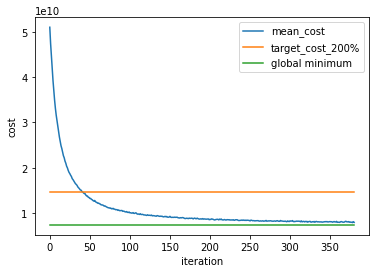

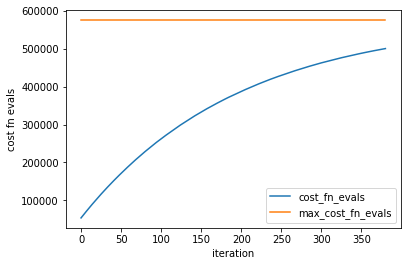

In [ ]:
"""
Hybrid + Elite
"""
niters = 1000
subiters = 10
popsize = 4

_costFnCounter={}
ga = lambda pop : eliteGA( pop, subiters, 2, 1, 50, 1, 1, False )[0]
_, hybrid_h = hybrid_ga( [ Individual() for _ in range(popsize) ], niters, ga )
plot_history( hybrid_h )

{'iteration': 0, 'mean_cost': 37316674764.8, 'cost_fn_evals': 130299}
Found notification: 14735154828.623959
{'iteration': 10, 'mean_cost': 14940722995.2, 'cost_fn_evals': 230852}
{'iteration': 10, 'mean_cost': 14940722995.2, 'cost_fn_evals': 230852}
{'iteration': 20, 'mean_cost': 11576944640.0, 'cost_fn_evals': 308890}
Found notification: 11051366121.467968
{'iteration': 22, 'mean_cost': 11272530841.6, 'cost_fn_evals': 322231}
{'iteration': 30, 'mean_cost': 10434761113.6, 'cost_fn_evals': 368844}
{'iteration': 40, 'mean_cost': 10004775526.4, 'cost_fn_evals': 415195}
{'iteration': 50, 'mean_cost': 9683666022.4, 'cost_fn_evals': 450953}
{'iteration': 60, 'mean_cost': 9558167859.2, 'cost_fn_evals': 478681}
Exceeded max cost functions, terminating


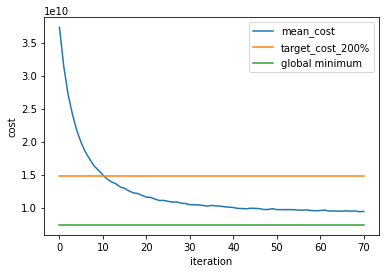

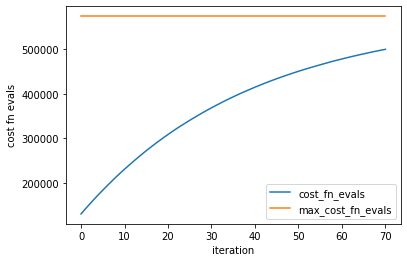

In [ ]:
"""
Hybrid + Generational
"""

niters = 1000
subiters = 10
popsize = 10

_costFnCounter={}
ga = lambda pop : genGA( pop, subiters, 1, 50, 1, 1, False )[0]
_, hybrid_h = hybrid_ga( [ Individual() for _ in range(popsize) ], niters, ga )
plot_history( hybrid_h )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


{'iteration': 0, 'mean_cost': 48611438592.0, 'cost_fn_evals': 40998}
{'iteration': 10, 'mean_cost': 17404252160.0, 'cost_fn_evals': 173137}
Found notification: 14735154828.623959
{'iteration': 15, 'mean_cost': 14317171712.0, 'cost_fn_evals': 228995}
{'iteration': 20, 'mean_cost': 12535940096.0, 'cost_fn_evals': 277635}
Found notification: 11051366121.467968
{'iteration': 28, 'mean_cost': 11040099328.0, 'cost_fn_evals': 342424}
{'iteration': 30, 'mean_cost': 10783647232.0, 'cost_fn_evals': 356429}
{'iteration': 40, 'mean_cost': 9858055680.0, 'cost_fn_evals': 415066}
{'iteration': 50, 'mean_cost': 9353933312.0, 'cost_fn_evals': 458046}
{'iteration': 60, 'mean_cost': 8936432128.0, 'cost_fn_evals': 489300}
Exceeded max cost functions, terminating


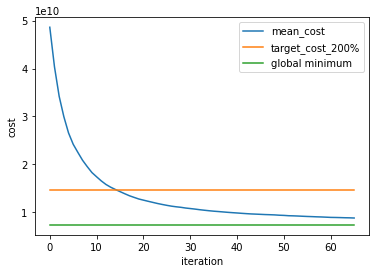

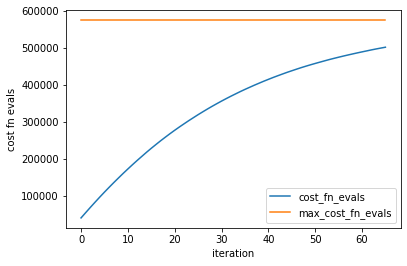

In [ ]:
"""
Hybrid + ABC
"""

niters = 1000
subiters = 40
popsize = 2

_costFnCounter={}
ga = lambda pop : BeeHive( pop, None ).run( subiters )[0]
_, hybrid_h = hybrid_ga( [ Individual() for _ in range(popsize) ], niters, ga )
plot_history( hybrid_h )